In [1]:
%%writefile task_06_mpi.py

import time
import numpy as np

from mpi4py import MPI


comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

nwindowsteps = 4000

# set timeline
t = np.linspace(-20*2*np.pi, 20*2*np.pi, 3**9 + 6)

# generate the signal
y = np.sin(t) * np.exp(-t**2 / (2 * 20**2)) + \
    np.sin(3*t) * np.exp(-(t - 5*2*np.pi)**2 / (2 * 20**2)) + \
    np.sin(5.5*t) * np.exp(-(t + 10*2*np.pi)**2 / (2 * 5**2))

window_positions = np.linspace(-20*2*np.pi, 20*2*np.pi, nwindowsteps)
window_width = 2.0 * 2 *np.pi

process_size = nwindowsteps // size

if rank == (size - 1):
    rank_window_positions = window_positions[process_size * rank:]
else:
    rank_window_positions = window_positions[process_size * rank:process_size * rank + process_size]

result = np.zeros((rank_window_positions.size, t.size))
for n, window_position in enumerate(rank_window_positions):
    window_function = np.exp(-(t - window_position)**2 / (2 * window_width**2))
    result[n] = abs(np.fft.fft(y * window_function))

sendcounts = np.array(comm.gather(result.size, 0))

specgram = np.zeros((window_positions.size, t.size)) if rank == 0 else None

comm.Gatherv(sendbuf=result, recvbuf=(specgram, sendcounts), root=0)

if rank == 0:
    specgram = specgram.T

Overwriting task_06_mpi.py


In [4]:
time_arr = []
for i in range(1, 11):
    print(f'Num of processes: {i},\t', end='')
    t = %timeit -o -r 3 !mpirun -n {i} --allow-run-as-root --mca btl ^vader python3 task_06_mpi.py
    time_arr.append(t.best)

Num of processes: 1,	19.4 s ± 1.7 s per loop (mean ± std. dev. of 3 runs, 1 loop each)
Num of processes: 2,	10.9 s ± 780 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Num of processes: 3,	7.11 s ± 288 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Num of processes: 4,	5.66 s ± 16.5 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Num of processes: 5,	4.8 s ± 17.8 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Num of processes: 6,	4.27 s ± 39.6 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Num of processes: 7,	3.93 s ± 24.7 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Num of processes: 8,	3.74 s ± 52.1 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Num of processes: 9,	3.51 s ± 23.7 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
Num of processes: 10,	3.41 s ± 13.9 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


Text(0.5, 1.0, 'SpeedUp vs number of processes')

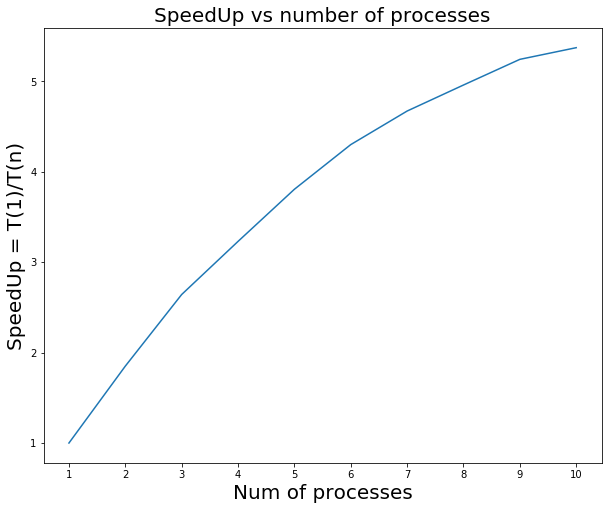

In [6]:
import numpy as np

from matplotlib import pyplot as plt


speedup = time_arr[0] / np.array(time_arr)
num_of_processes = range(1, 11)

plt.figure(figsize=(10, 8))
plt.plot(num_of_processes, speedup)
plt.xticks(num_of_processes)
plt.xlabel('Num of processes', fontsize=20)
plt.ylabel('SpeedUp = T(1)/T(n)', fontsize=20)
plt.title('SpeedUp vs number of processes', fontsize=20)